# ChemSpiPy: Spectra

Here are some examples of using ChemSpiPy to retrieve spectra from ChemSpider.

First we'll start by setting up our ChemSpider session in the usual way:

In [1]:
import os
from chemspipy import ChemSpider

In [2]:
# Security token is retrieved from environment variables
CHEMSPIDER_SECURITY_TOKEN = os.environ['CHEMSPIDER_SECURITY_TOKEN']
cs = ChemSpider(security_token=CHEMSPIDER_SECURITY_TOKEN)

## Retrieving Spectra

Get the spectra for a compound:

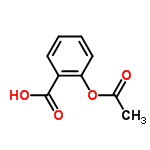

In [3]:
compound = cs.get_compound(2157)
compound

In [4]:
print(compound.csid)
print(compound.smiles)
print(compound.spectra)

2157
CC(=O)Oc1ccccc1C(=O)O
[Spectrum(2303), Spectrum(2304), Spectrum(3558), Spectrum(6639), Spectrum(6640), Spectrum(6641), Spectrum(6642), Spectrum(6643), Spectrum(6644), Spectrum(6645), Spectrum(8553), Spectrum(8554)]


Or get the spectra for all the results of a search:

In [5]:
for result in cs.search('glucose'):
    if result.spectra:
        print(result)
        print(result.spectra)

Compound(71358)
[Spectrum(360), Spectrum(361), Spectrum(3172)]
Compound(96749)
[Spectrum(362), Spectrum(363)]


Alternatively, if you aren't interested in any of the other compound properties, you can get spectra directly by using either the compound ChemSpider ID or the Spectrum ID:

In [6]:
cs.get_spectrum(362)

Spectrum(362)

In [7]:
cs.get_compound_spectra(71358)

[Spectrum(360), Spectrum(361), Spectrum(3172)]

## Spectrum metadata

Each Spectrum object has a number of properties:

In [8]:
spectrum = cs.get_spectrum(3558)
print('Spectrum ID: %s' % spectrum.spectrum_id)
print('Compound ID: %s' % spectrum.csid)
print('Spectrum type: %s' % spectrum.spectrum_type)
print('File name: %s' % spectrum.file_name)
print('Comments: %s' % spectrum.comments)
print('Original URL: %s' % spectrum.original_url)
print('URL: %s' % spectrum.url)

Spectrum ID: 3558
Compound ID: 2157
Spectrum type: HNMR
File name: Spectrum_315.jdx
Comments: collected by David Bulger at Oral Roberts University on a JEOL 300 MHz NMR with methanol as the solvent
Original URL: http://onschallenge.wikispaces.com/Exp072
URL: http://www.chemspider.com/FilesHandler.ashx?type=blob&disp=1&id=3558


## Spectrum data

The data file for each spectrum is also available using the `data` property:

In [9]:
spectra = cs.get_compound_spectra(2424)
caffeine_ir = spectra[8]
print(caffeine_ir.data)

##TITLE=Caffeine
##JCAMP-DX=4.24
##DATA TYPE=INFRARED SPECTRUM
##ORIGIN=Sadtler Research Labs Under US-EPA Contract
##OWNER=NIST Standard Reference Data Program
##CAS REGISTRY NO=58-08-2
##MOLFORM=C 8 H 10 N 4 O 2
##XUNITS=1/CM
##YUNITS=ABSORBANCE
##XFACTOR=1.0
##YFACTOR=0.000149628
##DELTAX=4.0
##FIRSTX=450.0
##LASTX=3966.0
##FIRSTY=0.004489
##MAXX=3966
##MINX=450
##MAXY=1.49628
##MINY=0
##NPOINTS=880
##XYDATA=(X++(Y..Y))
450.0 30 46 38 120 79 193 340 391 388 250
490.0 145 11 40 45 17 45 22 81 7 50
530.0 18 68 11 30 38 26 59 38 48 6
570.0 41 14 30 21 41 39 50 116 118 194
610.0 202 155 88 71 32 33 33 29 46 29
650.0 35 21 33 10 37 40 17 29 27 41
690.0 22 40 26 39 26 33 31 17 32 41
730.0 91 137 209 249 296 304 406 323 280 341
770.0 195 156 98 83 43 39 48 43 59 52
810.0 82 68 112 146 194 248 244 163 116 88
850.0 43 50 24 39 23 26 21 31 29 16
890.0 34 19 34 14 38 29 41 54 70 91
930.0 88 80 35 43 33 45 51 80 121 181
970.0 296 370 411 354 264 147 88 79 113 180
1010.0 298 500 693 828 838 720 

We can do some quick-and-dirty parsing of the JCAMP-JDX file:

In [10]:
# See https://github.com/nzhagen/jcamp/ for more robust parsing

import numpy as np

xstart, xnum, y, meta = [], [], [], {}

for line in caffeine_ir.data.split('\n'):
    if line.startswith('##'):
        key, val = line.split('=', 1)
        meta[key.lstrip('#')] = val.strip()
    else:
        numbers = [float(n) for n in line.strip().split()]
        if numbers:
            xstart.append(numbers[0])
            xnum.append(len(numbers) - 1)
            for number in numbers[1:]:
                y.append(float(number))
xstart.append(float(meta['LASTX']))
x = np.array([])
for n in range(len(xnum)):
    x = np.append(x, np.linspace(xstart[n], xstart[n + 1], xnum[n]))  
y = np.array(y)
y = y * float(meta['YFACTOR'])

Then we can use matplotlib to plot it:

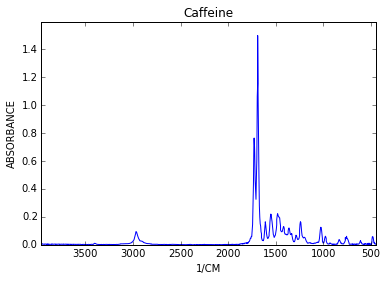

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel(meta['XUNITS'])
plt.ylabel(meta['YUNITS'])
plt.title(meta['TITLE'])
plt.axis([max(x), min(x), min(y), max(y) + 0.1])
plt.plot(x, y)